In [1]:
from IPython.display import display
import sys
import spot
from spot.jupyter import display_inline
import buddy
import pdb
spot.setup(show_default='.tvb')

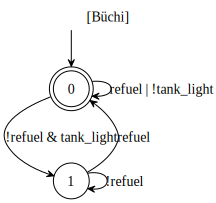

In [2]:
a1 = spot.translate('G(tank_light -> F(refuel))', 'Buchi', 'state-based', 'complete'); a1.show("v")

HOA: v1
States: 2
Start: 0
AP: 2 "tank_light" "refuel"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc complete
properties: deterministic stutter-invariant
--BODY--
State: 0 {0}
[!0 | 1] 0
[0&!1] 1
State: 1
[1] 0
[!1] 1
--END--


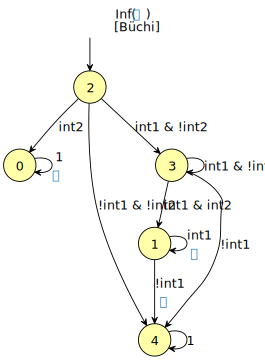

In [3]:
print(a1.to_str('hoa'))
a2 = spot.translate('G(!(empty)) & GF(park) & GF(home)')
a2 = spot.translate('G(!(empty))'); a2.show("v")
a2 = spot.translate('(G(int1)U(int2))', 'Buchi', 'state-based', 'complete'); a2

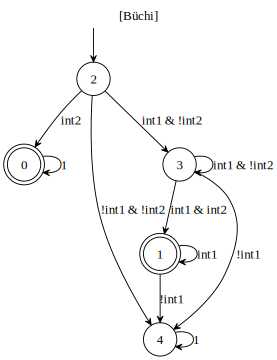

In [4]:
a2.show("v")

In [5]:
print(a2.to_str('hoa'))

HOA: v1
States: 5
Start: 2
AP: 2 "int1" "int2"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc complete
properties: deterministic stutter-invariant very-weak
--BODY--
State: 0 {0}
[t] 0
State: 1 {0}
[0] 1
[!0] 4
State: 2
[1] 0
[0&!1] 3
[!0&!1] 4
State: 3
[0&1] 1
[0&!1] 3
[!0] 4
State: 4
[t] 4
--END--


# Parsing twa_graph object to derive states:

In [6]:
def show_prod(a1, a2, res):
    s1 = a1.num_sets()
    display_inline(a1, a2.show('.tvb+{}'.format(s1)), res)

def prod(left, right):
    # A bdd_dict object associates BDD variables (that are 
    # used in BDDs labeleing the edges) to atomic propositions.
    bdict = left.get_dict()
    # If the two automata do not have the same BDD dict, then
    # we cannot easily detect compatible transitions.
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
    result = spot.make_twa_graph(bdict)
    # This will be our state dictionary
    sdict = {}
    # The list of output states for which we have not yet
    # computed the successors.  Items on this list are triplets
    # of the form (ls, rs, p) where ls,rs are the state number in
    # the left and right automata, and p is the state number if
    # the output automaton.
    todo = []
    # Transform a pair of state number (ls, rs) into a state number in
    # the output automaton, creating a new state if needed.  Whenever
    # a new state is created, we can add it to todo.
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            todo.append((ls, rs, p))
        return p
    
    # Setup the initial state.  It always exists.
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))
    # pdb.set_trace()
    # Build all states and edges in the product
    while todo:
        print(todo)
        lt_num = 0
        rt_num = 0
        lsrc, rsrc, osrc = todo.pop()
        print("----------------------------------")
        print(f"new edge in todo: ({lsrc}, {rsrc}, {osrc})")
        
        for lt in left.out(lsrc):
            lt_num += 1
            for rt in right.out(rsrc):
                rt_num += 1
                cond = lt.cond & rt.cond
                print(f"left cond: {lt.cond}")
                print(f"right cond: {rt.cond}")
                print(f"cond: {cond}")
                print("\n")
#                 print(f"buddy false: {buddy.bddfalse}")
#                 print(f"buddy true: {buddy.bddtrue}")
#                 print("Check if cond is the constant true bdd:")
                buddy.bdd_printdot(cond)
                if cond != buddy.bddfalse:
                    print(lt.dst)
                    print(rt.dst)
                    result.new_edge(osrc, dst(lt.dst, rt.dst), cond)
        print(f"No. of outgoing edges in left automata state {lt_num}")
        print(f"No. of outgoing edges in right automata state {rt_num}")

    return result

p1 = prod(a1, a2)
print(f"buddy false: {buddy.bddfalse}")
print(f"buddy true: {buddy.bddtrue}")

[(0, 2, 0)]
----------------------------------
new edge in todo: (0, 2, 0)
left cond: bdd(id=57)
right cond: bdd(id=62)
cond: bdd(id=398)


0
0
left cond: bdd(id=57)
right cond: bdd(id=99)
cond: bdd(id=400)


0
3
left cond: bdd(id=57)
right cond: bdd(id=120)
cond: bdd(id=402)


0
4
left cond: bdd(id=12)
right cond: bdd(id=62)
cond: bdd(id=404)


1
0
left cond: bdd(id=12)
right cond: bdd(id=99)
cond: bdd(id=406)


1
3
left cond: bdd(id=12)
right cond: bdd(id=120)
cond: bdd(id=408)


1
4
No. of outgoing edges in left automata state 2
No. of outgoing edges in right automata state 6
[(0, 0, 1), (0, 3, 2), (0, 4, 3), (1, 0, 4), (1, 3, 5), (1, 4, 6)]
----------------------------------
new edge in todo: (1, 4, 6)
left cond: bdd(id=6)
right cond: bdd(id=1)
cond: bdd(id=6)


0
4
left cond: bdd(id=7)
right cond: bdd(id=1)
cond: bdd(id=7)


1
4
No. of outgoing edges in left automata state 2
No. of outgoing edges in right automata state 2
[(0, 0, 1), (0, 3, 2), (0, 4, 3), (1, 0, 4), (1, 3, 5)]
---

In [7]:
# Defining asynchronous product:
def async_prod(left, right):
    bdict = left.get_dict()
    # If the two automata do not have the same BDD dict, then
    # we cannot easily detect compatible transitions.
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
    result = spot.make_twa_graph(bdict)
    result.copy_ap_of(left)
    result.copy_ap_of(right)
    # The list of output states for which we have not yet
    # computed the successors.  Items on this list are triplets
    # of the form (ls, rs, p) where ls,rs are the state number in
    # the left and right automata, and p is the state number if
    # the output automaton.
    todo = []
    sdict = {}
    pairs = []   # our array of state pairs
    # Transform a pair of state number (ls, rs) into a state number in
    # the output automaton, creating a new state if needed.  Whenever
    # a new state is created, we can add it to todo.
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            pairs.append(pair)
            todo.append((ls, rs, p))
        return p
    
    # Setup the initial state.  It always exists.
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))
    
    # The acceptance sets of the right automaton will be shifted by this amount
    shift = left.num_sets()
    # result.set_acceptance(shift + right.num_sets(), left.get_acceptance() | (right.get_acceptance() << shift))
    result.set_acceptance(shift + right.num_sets(),
                          left.get_acceptance() | (right.get_acceptance() << shift)) # Not sure if the and here means both acceptances.
    #pdb.set_trace()

    # Build all states and edges in the product
    while todo:
        print(todo)
        lsrc, rsrc, osrc = todo.pop()
        print("----------------------------------")
        print(f"new edge in todo: ({lsrc}, {rsrc}, {osrc})")
        
        for lt in left.out(lsrc):
            if lt.cond != buddy.bddfalse:
                result.new_edge(osrc, dst(lt.dst, rsrc), lt.cond, lt.acc)
                #result.new_edge(osrc, dst(lt.dst, rsrc), lt.cond)
                
        for rt in right.out(rsrc):
            if rt.cond != buddy.bddfalse:
                result.new_edge(osrc, dst(lsrc, rt.dst), rt.cond, rt.acc << shift)
                #result.new_edge(osrc, dst(lsrc, rt.dst), rt.cond)
                # membership of this transitions to the new acceptance sets
        
        # Remember the origin of our states
        result.set_product_states(pairs)
        
    # Loop over all the properties we want to preserve if they hold in both automata
    # This ensures that the product of NBAs is an NBA
#     for p in ('prop_complete', 'prop_weak', 'prop_inherently_weak', 
#               'prop_terminal', 'prop_stutter_invariant', 'prop_state_acc'):
#         if getattr(left, p)() and getattr(right, p)():
#             print(p)
#             getattr(result, p)(True)
    return result, sdict

[(0, 2, 0)]
----------------------------------
new edge in todo: (0, 2, 0)
[(1, 2, 1), (0, 0, 2), (0, 3, 3), (0, 4, 4)]
----------------------------------
new edge in todo: (0, 4, 4)
[(1, 2, 1), (0, 0, 2), (0, 3, 3), (1, 4, 5)]
----------------------------------
new edge in todo: (1, 4, 5)
[(1, 2, 1), (0, 0, 2), (0, 3, 3)]
----------------------------------
new edge in todo: (0, 3, 3)
[(1, 2, 1), (0, 0, 2), (1, 3, 6), (0, 1, 7)]
----------------------------------
new edge in todo: (0, 1, 7)
[(1, 2, 1), (0, 0, 2), (1, 3, 6), (1, 1, 8)]
----------------------------------
new edge in todo: (1, 1, 8)
[(1, 2, 1), (0, 0, 2), (1, 3, 6)]
----------------------------------
new edge in todo: (1, 3, 6)
[(1, 2, 1), (0, 0, 2)]
----------------------------------
new edge in todo: (0, 0, 2)
[(1, 2, 1), (1, 0, 9)]
----------------------------------
new edge in todo: (1, 0, 9)
[(1, 2, 1)]
----------------------------------
new edge in todo: (1, 2, 1)


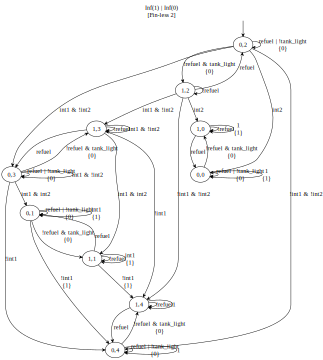

In [8]:
p2, states = async_prod(a1,a2)
# p2 = spot.product(a1,a2)
p2.show("v")
# To-Do: Plot the automata states differently based on which automata is responsible for which action.
# Propositions happen at different player states. Take into account this difference when constructing virtual product automata
# Tp = S * T, Bpi = B1 * B2 --> G = Tp o Bpi
# (??) Tsys = S o B1, Ttest = T o B2 ---> G = Tsys * Ttest; multi-agent LTL examples would shed light on this.

In [9]:
print(a1.ap())
print(a2.ap())
print(p2.ap())
states

(spot.formula("tank_light"), spot.formula("refuel"))
(spot.formula("int1"), spot.formula("int2"))
(spot.formula("tank_light"), spot.formula("refuel"), spot.formula("int1"), spot.formula("int2"))


{(0, 2): 0,
 (1, 2): 1,
 (0, 0): 2,
 (0, 3): 3,
 (0, 4): 4,
 (1, 4): 5,
 (1, 3): 6,
 (0, 1): 7,
 (1, 1): 8,
 (1, 0): 9}

In [10]:
# print(p2.to_str('hoa'))
p2_hoa = print(p2.to_str('hoa'))

HOA: v1
States: 10
Start: 0
AP: 4 "tank_light" "refuel" "int1" "int2"
Acceptance: 2 Inf(1) | Inf(0)
properties: trans-labels explicit-labels trans-acc complete
--BODY--
State: 0
[!0 | 1] 0 {0}
[0&!1] 1 {0}
[3] 2
[2&!3] 3
[!2&!3] 4
State: 1
[1] 0
[!1] 1
[3] 9
[2&!3] 6
[!2&!3] 5
State: 2
[!0 | 1] 2 {0}
[0&!1] 9 {0}
[t] 2 {1}
State: 3
[!0 | 1] 3 {0}
[0&!1] 6 {0}
[2&3] 7
[2&!3] 3
[!2] 4
State: 4
[!0 | 1] 4 {0}
[0&!1] 5 {0}
[t] 4
State: 5
[1] 4
[!1] 5
[t] 5
State: 6
[1] 3
[!1] 6
[2&3] 8
[2&!3] 6
[!2] 5
State: 7
[!0 | 1] 7 {0}
[0&!1] 8 {0}
[2] 7 {1}
[!2] 4 {1}
State: 8
[1] 7
[!1] 8
[2] 8 {1}
[!2] 5 {1}
State: 9
[1] 2
[!1] 9
[t] 9 {1}
--END--


In [11]:
def show_prod(a1, a2, res):
    s1 = a1.num_sets()
    display_inline(a1, a2.show('.tvb+{}'.format(s1)), res)

show_prod(a1, a2, p2)

Prefix:
Cycle:
  0,2
  |  refuel | !tank_light	{0}



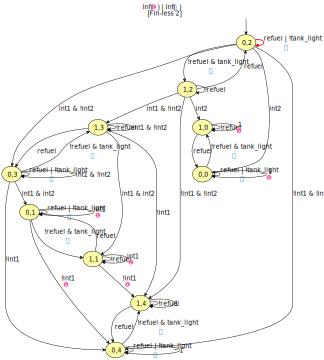

In [12]:
def show_accrun(aut):
    run = aut.accepting_run()
    print(run)
    run.highlight(5)
    display(aut)

show_accrun(p2)

In [13]:
p2.save('prodaut.aut', format='hoa', append=True)
with open('prodaut.aut') as f:
    product_aut_file = f.read()
f.close()

In [14]:
product_aut_file

'HOA: v1\nStates: 4\nStart: 0\nAP: 2 "tank_light" "refuel"\nAcceptance: 2 Inf(1) | Inf(0)\nproperties: trans-labels explicit-labels trans-acc complete\n--BODY--\nState: 0\n[!0 | 1] 0 {0}\n[0&!1] 1 {0}\n[1] 2\n[!1] 0\nState: 1\n[1] 0\n[!1] 1\n[1] 3\n[!1] 1\nState: 2\n[!0 | 1] 2 {0}\n[0&!1] 3 {0}\n[t] 2 {1}\nState: 3\n[1] 2\n[!1] 3\n[t] 3 {1}\n--END--\nHOA: v1\nStates: 10\nStart: 0\nAP: 4 "tank_light" "refuel" "int1" "int2"\nAcceptance: 2 Inf(1) | Inf(0)\nproperties: trans-labels explicit-labels trans-acc complete\n--BODY--\nState: 0\n[!0 | 1] 0 {0}\n[0&!1] 1 {0}\n[3] 2\n[2&!3] 3\n[!2&!3] 4\nState: 1\n[1] 0\n[!1] 1\n[3] 9\n[2&!3] 6\n[!2&!3] 5\nState: 2\n[!0 | 1] 2 {0}\n[0&!1] 9 {0}\n[t] 2 {1}\nState: 3\n[!0 | 1] 3 {0}\n[0&!1] 6 {0}\n[2&3] 7\n[2&!3] 3\n[!2] 4\nState: 4\n[!0 | 1] 4 {0}\n[0&!1] 5 {0}\n[t] 4\nState: 5\n[1] 4\n[!1] 5\n[t] 5\nState: 6\n[1] 3\n[!1] 6\n[2&3] 8\n[2&!3] 6\n[!2] 5\nState: 7\n[!0 | 1] 7 {0}\n[0&!1] 8 {0}\n[2] 7 {1}\n[!2] 4 {1}\nState: 8\n[1] 7\n[!1] 8\n[2] 8 {1}\n[!

In [15]:
def parse_hoa_file(file):
    with open(file) as f:
        lines = [line.rstrip('\n') for line in f]
    f.close()
    for l in lines:
        print(l)
    return lines

lines = parse_hoa_file('prodaut.aut')
print(len(lines))

HOA: v1
States: 4
Start: 0
AP: 2 "tank_light" "refuel"
Acceptance: 2 Inf(1) | Inf(0)
properties: trans-labels explicit-labels trans-acc complete
--BODY--
State: 0
[!0 | 1] 0 {0}
[0&!1] 1 {0}
[1] 2
[!1] 0
State: 1
[1] 0
[!1] 1
[1] 3
[!1] 1
State: 2
[!0 | 1] 2 {0}
[0&!1] 3 {0}
[t] 2 {1}
State: 3
[1] 2
[!1] 3
[t] 3 {1}
--END--
HOA: v1
States: 10
Start: 0
AP: 4 "tank_light" "refuel" "int1" "int2"
Acceptance: 2 Inf(1) | Inf(0)
properties: trans-labels explicit-labels trans-acc complete
--BODY--
State: 0
[!0 | 1] 0 {0}
[0&!1] 1 {0}
[3] 2
[2&!3] 3
[!2&!3] 4
State: 1
[1] 0
[!1] 1
[3] 9
[2&!3] 6
[!2&!3] 5
State: 2
[!0 | 1] 2 {0}
[0&!1] 9 {0}
[t] 2 {1}
State: 3
[!0 | 1] 3 {0}
[0&!1] 6 {0}
[2&3] 7
[2&!3] 3
[!2] 4
State: 4
[!0 | 1] 4 {0}
[0&!1] 5 {0}
[t] 4
State: 5
[1] 4
[!1] 5
[t] 5
State: 6
[1] 3
[!1] 6
[2&3] 8
[2&!3] 6
[!2] 5
State: 7
[!0 | 1] 7 {0}
[0&!1] 8 {0}
[2] 7 {1}
[!2] 4 {1}
State: 8
[1] 7
[!1] 8
[2] 8 {1}
[!2] 5 {1}
State: 9
[1] 2
[!1] 9
[t] 9 {1}
--END--
HOA: v1
States: 10
Start: 0
AP

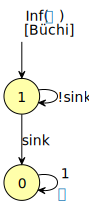

In [16]:
a_int = spot.translate('F(int)', 'Buchi', 'state-based', 'complete'); a_int
a_sink = spot.translate('F(sink)', 'Buchi', 'state-based', 'complete'); a_sink

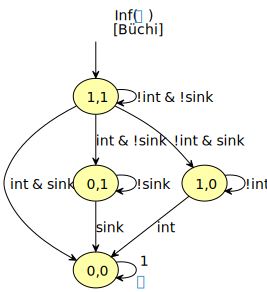

In [17]:
a_prod = spot.product(a_int, a_sink); a_prod

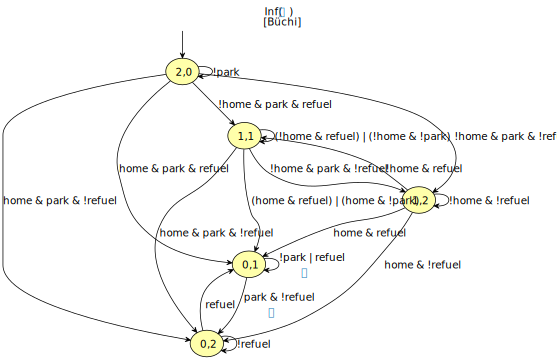

In [33]:
# Patrolling car asynchronous product automaton:
a_sys = spot.translate('F(park & F(home))', 'Buchi', 'state-based', 'complete')
a_test = spot.translate(' G(park -> F(refuel)) & F(park)', 'Buchi', 'state-based', 'complete')
a_sync_prod = spot.product(a_sys, a_test); a_sync_prod

[(2, 0, 0)]
----------------------------------
new edge in todo: (2, 0, 0)
[(0, 0, 1), (1, 0, 2), (2, 1, 3), (2, 2, 4)]
----------------------------------
new edge in todo: (2, 2, 4)
[(0, 0, 1), (1, 0, 2), (2, 1, 3), (0, 2, 5), (1, 2, 6)]
----------------------------------
new edge in todo: (1, 2, 6)
[(0, 0, 1), (1, 0, 2), (2, 1, 3), (0, 2, 5), (1, 1, 7)]
----------------------------------
new edge in todo: (1, 1, 7)
[(0, 0, 1), (1, 0, 2), (2, 1, 3), (0, 2, 5), (0, 1, 8)]
----------------------------------
new edge in todo: (0, 1, 8)
[(0, 0, 1), (1, 0, 2), (2, 1, 3), (0, 2, 5)]
----------------------------------
new edge in todo: (0, 2, 5)
[(0, 0, 1), (1, 0, 2), (2, 1, 3)]
----------------------------------
new edge in todo: (2, 1, 3)
[(0, 0, 1), (1, 0, 2)]
----------------------------------
new edge in todo: (1, 0, 2)
[(0, 0, 1)]
----------------------------------
new edge in todo: (0, 0, 1)


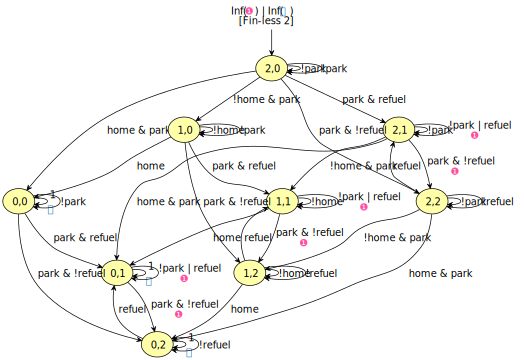

In [34]:
a_async_prod, states = async_prod(a_sys, a_test)
a_async_prod

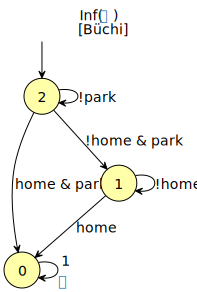

In [35]:
a_sys

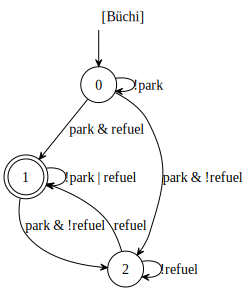

In [36]:
a_test.show("v")

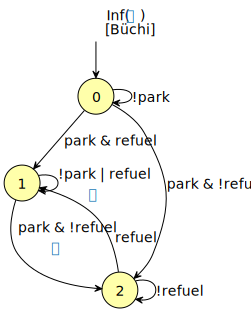

In [42]:
a_test = spot.translate('G(park -> F(refuel)) & F(park)', 'Buchi', 'state-based', 'complete'); a_test

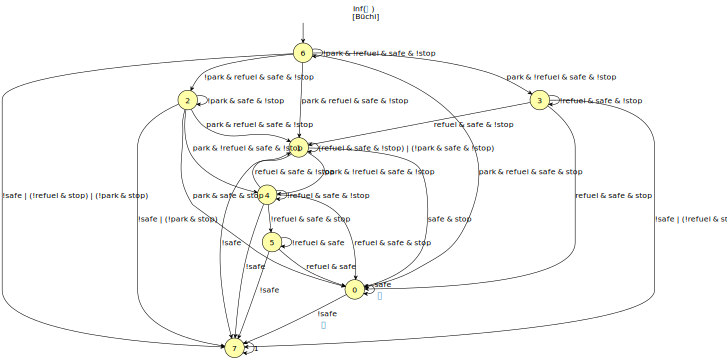

In [59]:
a_test = spot.translate('((park -> F(refuel)) U (stop)) & (!stop U park) & (!stop U refuel) & G(safe)', 'Buchi', 'state-based', 'complete'); a_test

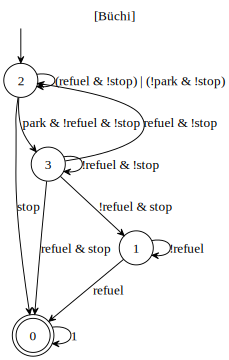

In [65]:
# Test automaton:
a_refuel = spot.translate('((park -> F(refuel)) U (stop))', 'Buchi', 'state-based', 'complete'); a_refuel.show("v")

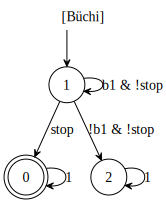

In [63]:
a_test.show("v") # ((park -> F(refuel)) U (stop)) & (!stop U refuel) & G(safe)

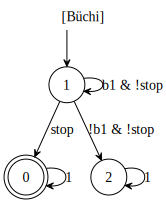

In [62]:
a_test = spot.translate('(b1) U (stop)', 'Buchi', 'state-based', 'complete'); a_test.show("v")

In [ ]:
# 1. Be careful about using stop, because you end up with one accepting state for system and tester --> no routing possible anymore.
# 2. Identify specific specs that we'd like to test (look at the specification pattern paper). Definitely, safety and reachability, and a limited class of trigger
# specifications. These trigger patterns might be different for system and tester
# 3. If test specification is long, neatly break it up into subspecifications that are conjuncted
# 4. No need to place 'G' in an until formula: (G(a)) U b is not sound. Instead, a U b will be enough
# 5. This specification seems promising: ((park -> F(refuel)) U (stop)) & (!stop U park) & (!stop U refuel) & G(safe) 

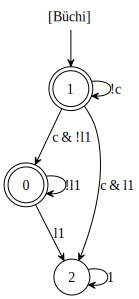

In [67]:
a = spot.translate('G(c -> G(!l1))', 'Buchi', 'state-based', 'complete'); a.show("v")